In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale


In [2]:
import os

# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
#pz_dir = '/Users/echarles/pz'

# use user home directory
#pz_dir = os.path.expanduser('~')

# use user home directory plus additional folder
#pz_dir = os.path.expanduser('~') + '/pz'
pz_dir = os.path.expanduser('~') + '/dev'

print("pz_dir:",pz_dir)

pz_dir: /home/phoenix/dev


In [3]:
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")
#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))
d = tables_io.read(f"{pz_dir}/data/on_sky/dp1_v29.0.0_gold_all.hdf5")


# uncomment if model files are located alongside data folder
model_file_knn = pz_dir + '/model_inform_knn.pkl'
model_file_bpz = pz_dir + '/model_inform_bpz.pkl'
model_file_fzb = pz_dir + '/model_inform_fzboost.pkl'
model_file_gpz = pz_dir + '/model_inform_gpz.pkl'

# uncomment if model files are located in same folder as the Jupyter notebook
#model_file_knn = './model_inform_knn.pkl'
#model_file_bpz = './model_inform_bpz.pkl'
#model_file_fzb = './model_inform_fzboost.pkl'
#model_file_gpz = './model_inform_gpz.pkl'

In [4]:
from rail.estimation.algos.k_nearneigh import KNearNeighEstimator
from rail.estimation.algos.bpz_lite import BPZliteEstimator
from rail.estimation.algos.flexzboost import FlexZBoostEstimator
from rail.estimation.algos.gpz import GPzEstimator
from rail.utils.catalog_utils import RubinCatalogConfig
RubinCatalogConfig.apply(RubinCatalogConfig.tag)
band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [5]:
train_features = raruma_util.get_band_values(train, '{band}_gaap1p0Mag', 'ugrizy')
error_bands = raruma_util.get_band_values(train, '{band}_gaap1p0MagErr', 'ugrizy')

In [6]:
library = raruma_util.get_band_values(d, '{band}_gaap1p0Mag', 'ugrizy')

In [7]:
knn = KNearNeighEstimator.make_stage(name='knn', model=model_file_knn, input='dummy.in', output_mode='return', nzbins=3001, calc_summary_stats=True)
knn.stage_columns = knn.config.bands
knn_w = raruma_wrap.CatEstimatorWrapper(knn, band_names, point_estimate='z_median')

Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn


In [20]:
from rail.estimation.algos.gpz import GPzEstimator

# Previous workaround for running gpz model - worked with doit() pre-uncertainty code
#gpz = KNearNeighEstimator.make_stage(name='gpz', model=model_file_gpz, input='dummy.in', output_mode='return', nzbins=3001)

# Create GPZ estimator for the gpz model 
gpz = GPzEstimator.make_stage(name='gpz', model=model_file_gpz, input='dummy.in', output_mode='return', nzbins=3001)
gpz.stage_columns = gpz.config.bands
#gpz_w = raruma_wrap.CatEstimatorWrapper(gpz, band_names) # previously used with old doit()
gpz_w = raruma_wrap.CatEstimatorWrapper(gpz, band_names + error_band_names) #pass error bands

Inserting handle into data store.  model: /home/phoenix/dev/model_inform_gpz.pkl, gpz


In [9]:
bpz = BPZliteEstimator.make_stage(name='bpz', model=model_file_bpz, input='dummy.in', output_mode='return', nzbins=3001)
bpz.stage_columns = bpz.config.bands
bpz_w = raruma_wrap.CatEstimatorWrapper(bpz, band_names+error_band_names)

In [10]:
fzb = FlexZBoostEstimator.make_stage(name='fzboost', model=model_file_fzb, input='dummy.in', output_mode='return', nzbins=3001, calc_summary_stats=True)
fzb.stage_columns = fzb.config.bands
fzb_w = raruma_wrap.CatEstimatorWrapper(fzb, band_names+error_band_names, point_estimate='z_mode')

In [11]:
admix_grid = np.logspace(-4, 0, 17)

In [12]:
band_names+error_band_names

['LSST_obs_u',
 'LSST_obs_g',
 'LSST_obs_r',
 'LSST_obs_i',
 'LSST_obs_z',
 'LSST_obs_y',
 'LSST_obs_u_err',
 'LSST_obs_g_err',
 'LSST_obs_r_err',
 'LSST_obs_i_err',
 'LSST_obs_z_err',
 'LSST_obs_y_err']

In [13]:
# Uncertainty extraction: calculates standard deviation of redshift PDFs
def calc_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)  # Get PDF values on grid
    norms = pdfs.sum(axis=1)  # Normalize
    means = np.sum(pdfs * grid, axis=1) / norms  # Calculate mean redshift
    diffs = (np.expand_dims(grid, -1) - means).T  # Distance from mean
    wt_diffs = diffs * diffs * pdfs  # Weighted squared differences
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)  # Standard deviation
    return np.expand_dims(stds, -1)

# Grid for uncertainty calculations
z_grid = np.linspace(0., 4., 401)

In [14]:
from rail.core.stage import RailStage
import qp

def doit(wrapper, nclip=3):
    the_dict = {}
    inputs = np.hstack([train_features, error_bands])
    est_orig = wrapper(inputs.T)

    # Record baseline uncertainty (before any contamination)
    RailStage.data_store.clear() # Clear data store before estimate
    wrapper._estimator.config.output_mode = 'default' # Enable file writing
    train_for_knn = {name: train_features[:, i] for i, name in enumerate(band_names)} # Create dict with LSST_obs_* column names
    if len(wrapper._param_names) > len(band_names):  # if wrapper expects error bands
        train_for_knn.update({name: error_bands[:, i] for i, name in enumerate(error_band_names)})
    baseline_handle = wrapper._estimator.estimate(train_for_knn) # Generate PDFs and save to file
    baseline_ensemble = qp.read(baseline_handle.path) # Read PDFs back from file
    uncertainty_base = calc_std(baseline_ensemble, z_grid) # Record uncertainty from PDFs 
    
    means = []
    stds = []
    outlier_fracs = []
    uncertainty_ratios = []
    
    for admix in admix_grid:
        mixed_mags = raruma_admix.make_admixture(train_features, library, admixture=admix)
        inputs = np.hstack([mixed_mags, error_bands])
        ad_vals = wrapper(inputs.T)

        # Record uncertainty with contamination and calculate ratio to baseline
        RailStage.data_store.clear() # Clear data store
        train_contam = {name: mixed_mags[:, i] for i, name in enumerate(band_names)} # Create dict with LSST_obs_* column names
        if len(wrapper._param_names) > len(band_names):  # if wrapper expects error bands
            train_contam.update({name: error_bands[:, i] for i, name in enumerate(error_band_names)})
        contam_handle = wrapper._estimator.estimate(train_contam) # Generate PDFs and save to file
        contam_ensemble = qp.read(contam_handle.path) # Read PDFs from file
        uncertainty_contam = calc_std(contam_ensemble, z_grid) # Record uncertainty from PDFs
        uncertainty_ratios.append(np.median(uncertainty_contam / uncertainty_base)) # >1 means uncertainty increased
        
        deltas = (ad_vals - est_orig)/(1 + est_orig)
        subset_clip, _, _ = sigmaclip(deltas, low=3, high=3)
        for _j in range(nclip):
            subset_clip, _, _ = sigmaclip(subset_clip, low=3, high=3)

        the_dict[admix] = deltas
        outliers = (np.fabs(deltas) > 0.15).sum() / float(deltas.size)
        outlier_fracs.append(outliers)
        #means.append(deltas.mean())
        #stds.append(deltas.std())
        means.append(biweight_location(subset_clip))
        stds.append(biweight_scale(subset_clip))

    _ = plt.plot(admix_grid, means, label=r"mean $\delta z$")
    _ = plt.plot(admix_grid, stds, label=r"RMS $\delta z$")
    _ = plt.plot(admix_grid, outlier_fracs, label=r"f $\delta z > 0.15$")
    _ = plt.plot(admix_grid, uncertainty_ratios, label="Uncertainty ratio")
    _ = plt.xscale('log')
    _ = plt.legend()
    _ = plt.xlabel("Flux Admixture Fraction")
    _ = plt.ylabel(r"$\delta z$")
    plt.show()

    return uncertainty_base, uncertainty_ratios, admix_grid

In [15]:
import os
for model_file in [pz_dir + '/model_inform_knn.pkl', pz_dir + '/model_inform_bpz.pkl', 
                   pz_dir + '/model_inform_fzboost.pkl', pz_dir + '/model_inform_gpz.pkl']:
    print(f"{model_file}: {os.path.exists(model_file)}")

/home/phoenix/dev/model_inform_knn.pkl: True
/home/phoenix/dev/model_inform_bpz.pkl: True
/home/phoenix/dev/model_inform_fzboost.pkl: True
/home/phoenix/dev/model_inform_gpz.pkl: True


In [16]:
import pickle
try:
    with open(pz_dir + '/model_inform_fzboost.pkl', 'rb') as f:
        model = pickle.load(f)
    print(f"Model type: {type(model)}")
    if isinstance(model, dict):
        print(f"Model keys: {model.keys()}")
except Exception as e:
    print(f"Error loading model: {e}")

/tmp/ipykernel_3101/2728526708.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  model = pickle.load(f)
/tmp/ipykernel_3101/2728526708.py:4: UserWarning: [19:50:30] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.read

Model type: <class 'flexcode.core.FlexCodeModel'>


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn


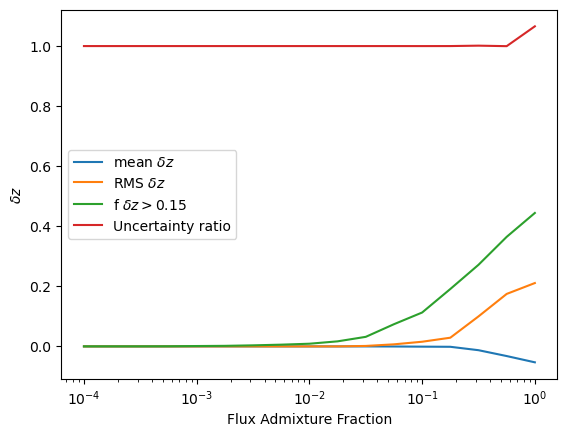

KNN worked

Uncertainty ratio range: 1.000 to 1.066
At highest contamination (admix=1.0000): ratio = 1.066


In [33]:
# variables to explore uncertianty comparisons
unc_base = None
unc_ratios = None
admix_vals = None

try:
    unc_base, unc_ratios, admix_vals = doit(knn_w)
#    doit(knn_w)
    print("KNN worked")
    print(f"\nUncertainty ratio range: {min(unc_ratios):.3f} to {max(unc_ratios):.3f}")
    print(f"At highest contamination (admix={admix_vals[-1]:.4f}): ratio = {unc_ratios[-1]:.3f}")
except Exception as e:
    print(f"KNN failed: {e}")

In [34]:
# Spot check: Compare baseline vs contaminated for middle admixture level
print("Baseline uncertainty stats:")
print(f"  Median: {np.median(unc_base):.4f}")
print(f"  Mean: {np.mean(unc_base):.4f}")
print(f"  Std: {np.std(unc_base):.4f}")

# Pick middle admixture level (index 8 out of 17)
test_idx = 8
test_admix = admix_vals[test_idx]
mixed_test = raruma_admix.make_admixture(train_features, library, admixture=test_admix)

RailStage.data_store.clear()
test_dict = {name: mixed_test[:, i] for i, name in enumerate(band_names)}
test_handle = knn_w._estimator.estimate(test_dict)
test_ensemble = qp.read(test_handle.path)
uncertainty_test = calc_std(test_ensemble, z_grid)

print(f"\nContaminated (admix={test_admix:.4f}) uncertainty stats:")
print(f"  Median: {np.median(uncertainty_test):.4f}")
print(f"  Mean: {np.mean(uncertainty_test):.4f}")
print(f"  Std: {np.std(uncertainty_test):.4f}")
print(f"\nRatio: {np.median(uncertainty_test / unc_base):.4f}")
print(f"Expected ratio from doit(): {unc_ratios[test_idx]:.4f}")

Baseline uncertainty stats:
  Median: 0.0264
  Mean: 0.0492
  Std: 0.0680
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803


/home/phoenix/miniconda3/envs/z-uncertainty/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1980: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn

Contaminated (admix=0.0100) uncertainty stats:
  Median: 0.0264
  Mean: 0.0495
  Std: 0.0700

Ratio: 1.0000
Expected ratio from doit(): 1.0000


In [35]:
doit(fzb_w)

Process 0 estimating PZ PDF for rows 0 - 4,803


AttributeError: 'dict' object has no attribute 'predict'

In [ ]:
doit(knn_w)

Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Inserting handle into data store.  input: dummy.in, gpz
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_gpz.pkl, gpz
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Inserting handle into data store.  input: dummy.in, gpz
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_gpz.pkl, gpz
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inpr

/home/phoenix/rail_raruma/src/rail/raruma/admixture_functions.py:51: RuntimeWarning: divide by zero encountered in divide
  pick_weights = total_fluxes / pick_totals
/home/phoenix/rail_raruma/src/rail/raruma/admixture_functions.py:52: RuntimeWarning: invalid value encountered in multiply
  contamination = (pick_fluxes.T * (pick_weights * admixture)).T


Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Inserting handle into data store.  input: dummy.in, gpz
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_gpz.pkl, gpz
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Inserting handle into data store.  input: dummy.in, gpz
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_gpz.pkl, gpz
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating GPz PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inpr

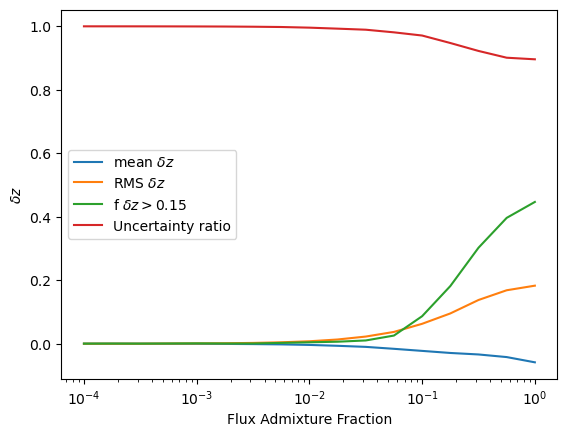

In [21]:
unc_base1 = None
unc_ratios1 = None
admix_vals1 = None

unc_base1, unc_ratios1, admix_vals1 = doit(gpz_w)

In [50]:
for k, v in the_dict.items():
    _ = plt.hist(v, bins=np.linspace(-1, 1, 101), label=k)

NameError: name 'the_dict' is not defined